# Azure VM Reliability Simulator

## 1. Create synthetic data with LLM Scenarios
## 2. Explore the data
## 3. Perform feature engineering 
## 4. Use Gradient Boosting to create a model with Time Series Split
## 5. Survival Analysis with Time_Varying Covariates
## 6. Streamlit Dashboard


## 1. Synthetic Data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Initialize GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium') 
model = GPT2LMHeadModel.from_pretrained('gpt2-medium') 

# Generate failure scenario using GPT-2
def generate_llm_failure_scenario():
    """Generate failure scenario using GPT-2"""
    prompt = "Azure VM failure scenario involving:"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=100, do_sample=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Convert LLM description to telemetry signature
def scenario_to_pattern(scenario: str):
    """Convert LLM description to telemetry signature"""
    pattern = {
        'cpu_util': np.random.normal(40, 5),
        'mem_util': np.random.normal(50, 5),
        'disk_io': np.random.exponential(80),
        'net_latency': np.random.gamma(2, 10)
    }
    
    # Pattern adjustments based on keywords
    if 'CPU' in scenario or 'compute' in scenario:
        pattern['cpu_util'] = min(100, pattern['cpu_util'] * 1.8)
    if 'memory' in scenario or 'RAM' in scenario:
        pattern['mem_util'] = min(100, pattern['mem_util'] * 1.7)
    if 'disk' in scenario or 'storage' in scenario:
        pattern['disk_io'] = pattern['disk_io'] * 3.5
    if 'network' in scenario or 'latency' in scenario:
        pattern['net_latency'] = pattern['net_latency'] * 4.0
        
    return pattern

# Generate synthetic data
def generate_azure_vm_data(num_vms=1000, days=90):
    np.random.seed(42)
    vm_ids = [f"vm_{i:04d}" for i in range(num_vms)]
    dates = [datetime.now() - timedelta(days=x) for x in range(days)]
    
    # Pre-generate failure scenarios
    failure_scenarios = [generate_llm_failure_scenario() for _ in range(20)]
    failure_history = {vm: [] for vm in vm_ids}  # Track failure clusters

    data = []
    for vm_id in vm_ids:
        sys_failures = 0
        for i, date in enumerate(dates):
            # Apply failure history decay (temporal dependency)
            cluster_effect = 0.8 ** sys_failures

            is_failure = False
            if np.random.random() < (0.15 * cluster_effect):  # Failure event
                scenario = np.random.choice(failure_scenarios)
                pattern = scenario_to_pattern(scenario)
                sys_failures += 1
                is_failure = True
                failure_history[vm_id].append((date, scenario))
            else:
                # Baseline with failure history influence
                stress_factor = 1 + (0.3 * cluster_effect)
                pattern = {
                    'cpu_util': min(100, np.random.normal(40, 10) * stress_factor),
                    'mem_util': min(100, np.random.normal(50, 10) * stress_factor),
                    'disk_io': np.random.exponential(100) * stress_factor,
                    'net_latency': np.random.gamma(2, 15) * stress_factor
                }
                
            data.append({
                "vm_id": vm_id,
                "timestamp": date,
                "sys_failures": 1 if is_failure else 0,
                "cumulative_failures" : sys_failures,
                **pattern
            })
            
            # Decay failure counter weekly
            if i % 7 == 0:
                sys_failures = max(0, sys_failures - 1)
                
    return pd.DataFrame(data), failure_history

# Generate data
df, failure_history = generate_azure_vm_data()
df.to_csv("azure_vm_telemetry_1.csv", index=False)

/Users/AndreaLopera/.global-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Sett

## 2. Explore the data

In [2]:
import pandas as pd
df = pd.read_csv("azure_vm_telemetry_1.csv")

count_of_zeros = (df['sys_failures'] == 0).sum()
print(f"Number of rows with 'sys_failures' == 0: {count_of_zeros}")

count_of_ones =(df['sys_failures'] == 1).sum()
print(f"Number of rows with 'sys_failures' == 1: {count_of_ones}")

Number of rows with 'sys_failures' == 0: 78881
Number of rows with 'sys_failures' == 1: 11119


In [3]:
df.head()

,vm_id,timestamp,sys_failures,cumulative_failures,cpu_util,mem_util,disk_io,net_latency
0,vm_0000,2025-08-07 21:03:32.240526,0,0,37.545558,69.145728,22.047518,90.669431
1,vm_0000,2025-08-06 21:03:32.240535,0,0,61.976651,58.896833,26.088269,48.161382
2,vm_0000,2025-08-05 21:03:32.240537,0,0,18.036863,77.354806,44.748989,13.089225
3,vm_0000,2025-08-04 21:03:32.240538,0,0,56.085215,84.053434,28.955662,27.141118
4,vm_0000,2025-08-03 21:03:32.240539,0,0,53.588849,58.299336,24.304963,19.603047


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vm_id                90000 non-null  object 
 1   timestamp            90000 non-null  object 
 2   sys_failures         90000 non-null  int64  
 3   cumulative_failures  90000 non-null  int64  
 4   cpu_util             90000 non-null  float64
 5   mem_util             90000 non-null  float64
 6   disk_io              90000 non-null  float64
 7   net_latency          90000 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 5.5+ MB


In [5]:
df.describe()

,sys_failures,cumulative_failures,cpu_util,mem_util,disk_io,net_latency
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,0.123544,1.074656,48.616729,61.071452,124.170514,37.144628
std,0.329063,1.016423,12.396231,12.782504,130.604555,28.711954
min,0.000000,0.000000,-0.879528,10.778869,0.003411,0.046166
25%,0.000000,0.000000,39.940775,51.669782,34.492310,16.906817
50%,0.000000,1.000000,47.776815,60.371294,83.816886,30.076527
75%,0.000000,2.000000,56.882303,69.838836,169.850436,49.634690
max,1.000000,6.000000,100.000000,100.000000,2283.045416,468.904535


## 3. Feature Engineering 

In [6]:
# # Feature engineering
## Sort data by VM and timestamp for accurate time-series calculations
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['vm_id', 'timestamp'])

## Time-Series features (Moving Averages)
### Set timestamp as index since when using groupby the time index is discarded
df_indexed = df.set_index('timestamp')
### Calculate the 7-day moving average for cpu_util
df_indexed['cpu_util_7d_avg'] = df_indexed.groupby('vm_id')['cpu_util'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
### Calculate the 7-day moving average for moving average for disk_io
df_indexed['disk_io_7d_avg'] = df_indexed.groupby('vm_id')['disk_io'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

# Convert the timestamp index back into a column
df = df_indexed.reset_index()

## Time-Based Features: features derived directly from the timestamp
df['hour'] = df['timestamp'].dt.hour
df['is_peak'] = df['hour'].between(8, 18).astype(int)

## Basic Interaction Features
df['cpu_mem_ratio'] = df['cpu_util'] / (df['mem_util'] + 1e-5)
df['cpu_disk_interaction'] = df['cpu_util'] * df['disk_io']

## Define Failure
df['failure'] = ((df['cpu_util'] > 90) & (df['disk_io'] > 250)).astype(int)

# Save this new dataframe for model training
df.to_csv('processed_vm_telemetry.csv', index=False)

In [7]:
df = pd.read_csv("processed_vm_telemetry.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             90000 non-null  object 
 1   vm_id                 90000 non-null  object 
 2   sys_failures          90000 non-null  int64  
 3   cumulative_failures   90000 non-null  int64  
 4   cpu_util              90000 non-null  float64
 5   mem_util              90000 non-null  float64
 6   disk_io               90000 non-null  float64
 7   net_latency           90000 non-null  float64
 8   cpu_util_7d_avg       90000 non-null  float64
 9   disk_io_7d_avg        90000 non-null  float64
 10  hour                  90000 non-null  int64  
 11  is_peak               90000 non-null  int64  
 12  cpu_mem_ratio         90000 non-null  float64
 13  cpu_disk_interaction  90000 non-null  float64
 14  failure               90000 non-null  int64  
dtypes: float64(8), int6

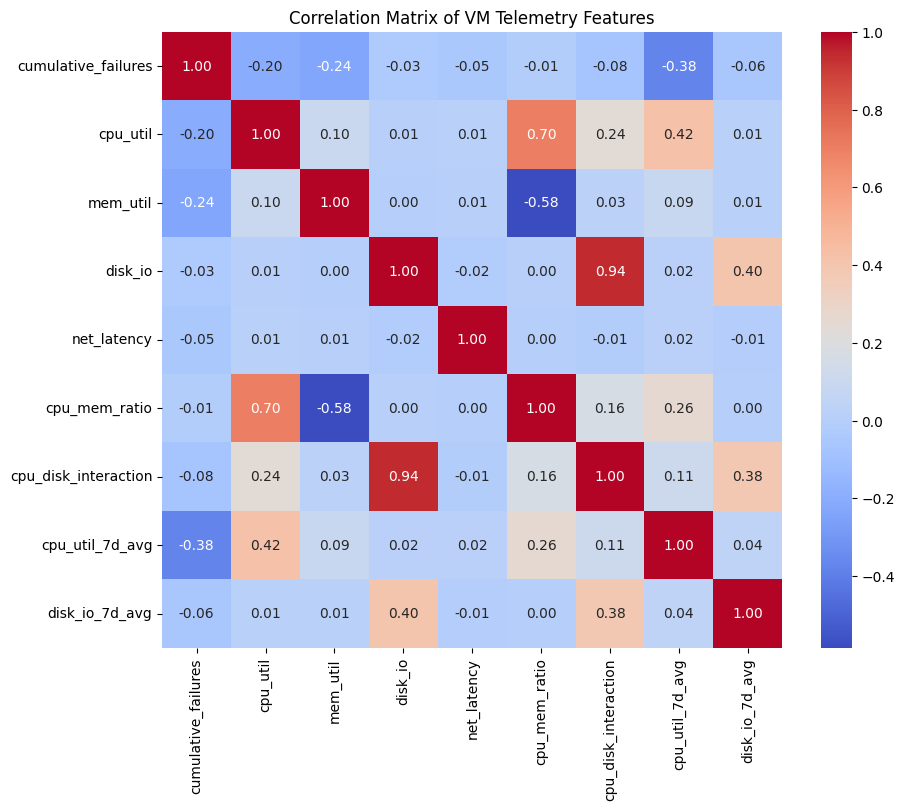

In [8]:
# Find out if independent numerical variables are correlated
import seaborn as sns
import matplotlib.pyplot as plt
numerical_variables = df[['cumulative_failures', 'cpu_util', 'mem_util',
       'disk_io', 'net_latency', 'cpu_mem_ratio',
       'cpu_disk_interaction', 'cpu_util_7d_avg', 'disk_io_7d_avg']]

correlation_matrix = numerical_variables.corr()

# Plot a headmap
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of VM Telemetry Features')
plt.show()

### Observations:
High-Correlation Issues 
- Severe Collinearity (|r| > 0.9):
disk_io vs cpu_disk_interaction (r = 0.94)
*Action:* Drop cpu_disk_interaction (keep raw disk_io)

- Moderate Collinearity (|r| > 0.7):
cpu_util vs cpu_mem_ratio (r = 0.71)
*Action:* Drop cpu_mem_ratio (redundant with CPU/Mem)

- Suspicious Relationships:
disk_io vs disk_io_7d_avg (r = 0.40)
cpu_disk_interaction vs disk_io_7d_avg (r = 0.38)
*Action:* We should keep both and keep monitoring

### 2. Gradient Boosting

#### Two different models: The difference lands on the way the data is split for training.
#### - Sorting the entire dataset by time before the split
#### - Splitting the data by vm_id first, and then apply TimeSeriesSplit to each VM's data

In [9]:
# Divide independent features and dependent feature
X_model_1 = df[['cumulative_failures', 'cpu_util', 'mem_util', 'disk_io', 'net_latency', 'cpu_util_7d_avg', 'disk_io_7d_avg']]
y_model_1 = df['failure']

### Model 1 : Sorting the entire dataset by time before the split

In [11]:
# Validation score sorting the database by time 
# Import libraries 
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt

# Generate the split
tss = TimeSeriesSplit(n_splits=3)

# Initialize a list to store accuracies
accuracies = []

# Loop through the time series splits to validate the model's performance
# The last iteration will hold the final, most-recent trained model
for train_index, test_index in tss.split(X_model_1):
    X_train, X_test = X_model_1.iloc[train_index], X_model_1.iloc[test_index]
    y_train, y_test = y_model_1.iloc[train_index], y_model_1.iloc[test_index]
    
    # Initialize a fresh model for each fold
    model = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"Fold Accuracy: {acc:.4f}")

# Print the average accuracy to get a better sense of performance
print(f"Average Fold Accuracy: {np.mean(accuracies):.4f}")

Fold Accuracy: 0.9997
Fold Accuracy: 0.9997
Fold Accuracy: 0.9998
Average Fold Accuracy: 0.9998


 98%|===================| 87836/90000 [00:22<00:00]        

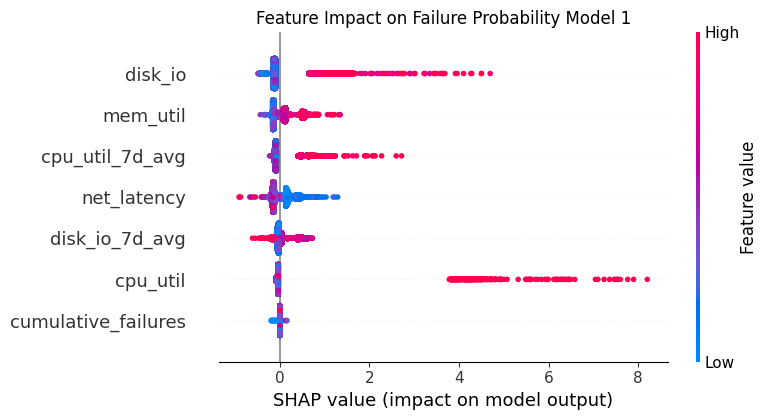

In [12]:
# Train the final model on the entire dataset after cross-validation
model_1 = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1)
model_1.fit(X_model_1, y_model_1)

# Now use this final model for the SHAP explanation
explainer_1 = shap.Explainer(model_1, X_model_1)
shap_values_1 = explainer_1(X_model_1)

# Visualize feature impacts 
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_1, show=False)
plt.title("Feature Impact on Failure Probability Model 1")
plt.tight_layout()
plt.savefig('feature_impact.png')

## Model Interpretability
### Instead of just knowing what percentage the model is accurate, let's analyze why the model made a particular decision for a specific data point "model's thought process."

- Using the data from the last split: The data that our final model instance was evaluated on

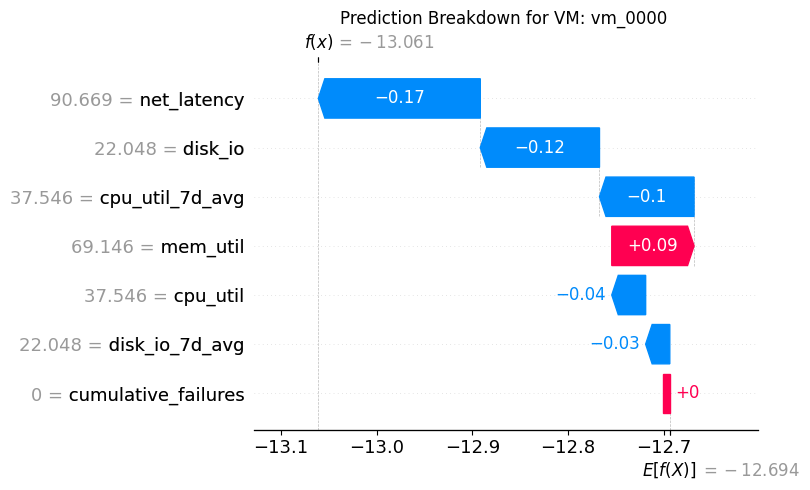

In [13]:
# Waterfall plot for specific VM (e.g., first in test set)
# Reset index to ensure we have access to the original data
X_test = X_test.reset_index(drop=False)

# Get VM ID for the first sample
vm_id = df.loc[X_test.index[0], 'vm_id']

# Plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_1[0], show=False)
plt.title(f"Prediction Breakdown for VM: {vm_id} ")
plt.tight_layout()
plt.savefig('shap_waterfall_1.png')

### Observation:
Based on this waterfall plot, the model's prediction of "no failure" for vm_0000 is primarily driven by its high network latency and disk I/O, both of which the model associates with a healthy, functioning machine. The other features, including cpu_util, had minimal to no impact on the final prediction for this particular instance.
- E[f(X)]=−12.694: This is the baseline prediction. It represents the average model output across all samples in the training dataset --the starting point for the prediction.

- f(x)=−13.1: This is the final prediction for vm_0000. In the context of a classifier, a more negative value suggests a lower probability of a "positive" outcome (in this case, failure). The final prediction is slightly more negative than the baseline, indicating that the model is quite confident that this VM will not fail. 

In [14]:
print(f"SHAP values type: {type(shap_values_1)}")
print(f"SHAP values shape: {shap_values_1.shape}")
print(f"SHAP values content: {shap_values_1}")

SHAP values type: <class 'shap._explanation.Explanation'>
SHAP values shape: (90000, 7)
SHAP values content: .values =
array([[ 0.        , -0.0353843 ,  0.08591893, ..., -0.16912096,
        -0.09873994, -0.02521165],
       [ 0.        , -0.0358789 , -0.13044757, ..., -0.14659995,
        -0.09174181, -0.02990399],
       [ 0.        , -0.04200499,  0.53821488, ...,  0.17002173,
        -0.09155755, -0.05001917],
       ...,
       [ 0.00082311, -0.04216742, -0.1521567 , ...,  0.36257836,
        -0.09464676, -0.02990399],
       [ 0.00073934, -0.03640683,  0.08620212, ..., -0.16912096,
        -0.09873994, -0.02521165],
       [ 0.00073934, -0.03775385, -0.13044757, ..., -0.11490301,
        -0.0917582 , -0.02990399]])

.base_values =
array([-12.69386046, -12.69386046, -12.69386046, ..., -12.69386046,
       -12.69386046, -12.69386046])

.data =
array([[ 0.        , 37.54555847, 69.1457284 , ..., 90.66943104,
        37.54555847, 22.04751795],
       [ 0.        , 61.97665148, 58.89

### 3. Survival Analysis

In [15]:
import numpy as np
from lifelines import CoxTimeVaryingFitter
from sklearn.preprocessing import StandardScaler

# 1. Time variables using actual time
# 'start' and 'end' columns are crucial for time-varying analysis
df['start'] = df.groupby('vm_id')['timestamp'].rank(method='first').astype(int) - 1
df['end'] = df['start'] + 1
df['event'] = df['failure']

# 3. Feature engineering
survival_features = ['cumulative_failures', 'cpu_util', 'mem_util', 'disk_io', 'net_latency', 'cpu_util_7d_avg', 'disk_io_7d_avg']  

# 4. Outlier handling and scaling
scaler = StandardScaler()
for col in survival_features:
    q1, q99 = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], q1, q99).fillna(df[col].mean())

df[survival_features] = scaler.fit_transform(df[survival_features])

# 5. Model fitting
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(
    df[['vm_id', 'start', 'end', 'event'] + survival_features],
    id_col='vm_id',
    event_col='event',
    start_col='start',
    stop_col='end',
    show_progress=True
)

# 6. Results
print(ctv.summary)
ctv.plot()
plt.tight_layout()
plt.savefig('survival_plot_1.png', dpi=300)

Iteration 1: norm_delta = 4.74e-03, step_size = 0.9500, log_lik = -82.89306, newton_decrement = 1.12e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.37e-04, step_size = 0.9500, log_lik = -82.78115, newton_decrement = 2.80e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.18e-05, step_size = 0.9500, log_lik = -82.78087, newton_decrement = 7.01e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.24e-07, step_size = 1.0000, log_lik = -82.78087, newton_decrement = 1.75e-09, seconds_since_start = 0.0
Convergence completed after 4 iterations.
                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
cumulative_failures -0.000987   0.999013  0.010534       -0.021634   
cpu_util             0.003319   1.003325  0.010534       -0.017326   
mem_util             0.000734   1.000734  0.010534       -0.019912   
disk_io              0.002565   1.002568  0.010534       -0.018081   
net_latenc

/Users/AndreaLopera/.global-venv/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column cpu_util have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'cpu_util'].var())
>>> print(df.loc[~events, 'cpu_util'].var())

A very low variance means that the column cpu_util completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [16]:
from lifelines.utils import concordance_index
c_index = concordance_index(
    event_times=df['end'],
    event_observed=df['event'],
    predicted_scores=-ctv.predict_partial_hazard(df)
)
print(f"Concordance Index: {c_index:.3f}")

Concordance Index: 0.995


In [17]:
print("\nDescriptive statistics for survival features:")
print(df[survival_features].describe())


Descriptive statistics for survival features:
       cumulative_failures      cpu_util      mem_util       disk_io  \
count         9.000000e+04  9.000000e+04  9.000000e+04  9.000000e+04   
mean          7.958079e-17  8.715991e-17  7.399118e-16  1.021603e-16   
std           1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min          -1.066297e+00 -2.256227e+00 -2.181177e+00 -9.960352e-01   
25%          -1.066297e+00 -7.133622e-01 -7.475444e-01 -7.227309e-01   
50%          -7.093605e-02 -6.908256e-02 -5.580463e-02 -3.179566e-01   
75%           9.244248e-01  6.795711e-01  6.968317e-01  3.880640e-01   
max           2.915146e+00  2.494631e+00  2.473408e+00  3.967948e+00   

        net_latency  cpu_util_7d_avg  disk_io_7d_avg  
count  9.000000e+04     9.000000e+04    9.000000e+04  
mean   1.042129e-16    -1.225291e-16   -6.252776e-16  
std    1.000006e+00     1.000006e+00    1.000006e+00  
min   -1.267447e+00    -2.306880e+00   -1.773016e+00  
25%   -7.374064e-01    -6.931

In [18]:
# from lifelines import CoxTimeVaryingFitter

# # Prepare survival data
# df = df.sort_values(['vm_id', 'timestamp'])
# df['start'] = (df['timestamp'] - df['timestamp'].min()).dt.days
# df['end'] = df['start'] + 1  # Daily intervals
# df['event'] = df['failure']

# # CTV model
# ctv = CoxTimeVaryingFitter(penalizer=0.1)
# ctv.fit(df[['vm_id', 'start', 'end', 'event', 'cpu_util', 'disk_io', 'sys_failures']],
#         id_col='vm_id',
#         event_col='event',
#         start_col='start',
#         stop_col='end')

# print(ctv.summary)
# ctv.plot()
# plt.tight_layout()
# plt.savefig('survival_plot.png')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Get baseline survival
baseline_survival = ctv.baseline_survival_

# 2. Create reference individual (median values)
reference = df[survival_features].median().to_frame().T
reference_scaled = scaler.transform(reference)
reference_df = pd.DataFrame(reference_scaled, columns=survival_features)

# 3. Compute partial hazard for reference
partial_hazard_reference = np.exp(ctv.predict_partial_hazard(reference_df).values[0])

# 4. Create comparison individuals
comparisons = [
    {'cpu_util': 30},
    {'cpu_util': 60},
    {'cpu_util': 90}
]

plt.figure(figsize=(10, 6))

for i, values in enumerate(comparisons):
    # Create individual profile
    individual = reference.copy()
    for feature, value in values.items():
        individual[feature] = value
    
    # Scale features
    individual_scaled = scaler.transform(individual)
    individual_df = pd.DataFrame(individual_scaled, columns=survival_features)
    
    # Compute partial hazard
    partial_hazard = np.exp(ctv.predict_partial_hazard(individual_df).values[0])
    
    # Calculate relative risk
    relative_risk = partial_hazard / partial_hazard_reference
    
    # Compute survival curve
    survival_curve = baseline_survival ** relative_risk
    
    # Plot
    plt.plot(survival_curve, label=f"CPU={values['cpu_util']}%")

plt.xlabel('Time (hours)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by CPU Utilization Model 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('survival_curves_cpu_1.png', dpi=300)

In [20]:
# Save artifacts for dashboard
import joblib
import shap
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter
import pickle

# 1. Save Model (XGBoost)
joblib.dump(model_1, 'model.pkl')

# 2. Save Survival Model
with open('survival_model_1.pkl', 'wb') as file:
    pickle.dump(ctv, file)

# 3. Save SHAP Explainer
# - For Tree-based models
joblib.dump(explainer_1, 'shap_explainer_1.joblib')

# - For non-tree models (alternative)
with open('shap_explainer_1.pkl', 'wb') as f:
    pickle.dump(explainer_1, f)

# 4. Save Dataset
df.to_csv('vm_telemetry_1.csv')

# 5. Save Failure History
np.save('failure_history_1.npy', failure_history, allow_pickle=True)
# Alternative: joblib.dump(failure_history, 'failure_history.joblib')

# 6. Save Feature Names (Critical!)
with open('feature_names_1.txt', 'w') as f:
    f.write(','.join(X_train.columns.tolist()))